## Light curves for single DIA Object

Author: Sandro

Last updated: 2025-01-15 by Sandro

In this notebook we will compute the light curves, in different bands, for a single DIA Object.

In [1]:
import hats
import lsdb
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt

## Loading the data

In [29]:
lsdb_dir = "/sdf/data/rubin/shared/lsdb_commissioning"
hats_dir = f"{lsdb_dir}/or4_dia/hats"

First, let's check what columns are useful for our use case:

In [3]:
hats.read_hats(f"{hats_dir}/DiaObject-dedup").schema

_healpix_29: int64
diaObjectId: int64
validityStart: timestamp[ns, tz=UTC]
validityEnd: timestamp[ns, tz=UTC]
ra: double
raErr: double
dec: double
decErr: double
ra_dec_Cov: double
radecMjdTai: double
pmRa: null
pmRaErr: null
pmDec: null
pmDecErr: null
parallax: null
parallaxErr: null
pmRa_pmDec_Cov: null
pmRa_parallax_Cov: null
pmDec_parallax_Cov: null
pmParallaxLnL: null
pmParallaxChi2: null
pmParallaxNdata: int64
u_psfFluxMean: null
u_psfFluxMeanErr: null
u_psfFluxSigma: null
u_psfFluxChi2: null
u_psfFluxNdata: int64
u_fpFluxMean: null
u_fpFluxMeanErr: null
u_fpFluxSigma: null
g_psfFluxMean: double
g_psfFluxMeanErr: double
g_psfFluxSigma: double
g_psfFluxChi2: double
g_psfFluxNdata: int64
g_fpFluxMean: null
g_fpFluxMeanErr: null
g_fpFluxSigma: null
r_psfFluxMean: double
r_psfFluxMeanErr: double
r_psfFluxSigma: double
r_psfFluxChi2: double
r_psfFluxNdata: int64
r_fpFluxMean: null
r_fpFluxMeanErr: null
r_fpFluxSigma: null
i_psfFluxMean: double
i_psfFluxMeanErr: double
i_psfFluxSigma: 

Let's load the `DiaObjects` catalog and nest the respective sources:

In [4]:
diaObj = lsdb.read_hats(f"{hats_dir}/DiaObject-dedup", columns=["diaObjectId", "ra", "dec"])
diaObj

,diaObjectId,ra,dec
npartitions=103,,,
"Order: 6, Pixel: 31150",int64[pyarrow],double[pyarrow],double[pyarrow]
"Order: 7, Pixel: 124604",...,...,...
...,...,...,...
"Order: 7, Pixel: 195011",...,...,...
"Order: 6, Pixel: 48753",...,...,...


In [5]:
diaSource = lsdb.read_hats(
    f"{hats_dir}/DiaSource", 
    columns=[
        "diaObjectId",
        "ra",
        "dec",
        "midpointMjdTai",
        "band",
        "psfFlux",
        "psfFluxErr",
        "scienceFlux",
        "scienceFluxErr"
    ])
diaSource

,diaObjectId,ra,dec,midpointMjdTai,band,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr
npartitions=101,,,,,,,,,
"Order: 6, Pixel: 31150",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow]
"Order: 7, Pixel: 124604",...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
"Order: 6, Pixel: 48752",...,...,...,...,...,...,...,...,...
"Order: 6, Pixel: 48753",...,...,...,...,...,...,...,...,...


In [6]:
diaObj = diaObj.join_nested(diaSource, left_on="diaObjectId", right_on="diaObjectId", nested_column_name="source")
diaObj

/sdf/home/s/stavar/.local/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,diaObjectId,ra,dec,source
npartitions=110,,,,
"Order: 6, Pixel: 31150",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<ra: [double], dec: [double], midpointMj..."
"Order: 7, Pixel: 124604",...,...,...,...
...,...,...,...,...
"Order: 7, Pixel: 195011",...,...,...,...
"Order: 6, Pixel: 48753",...,...,...,...


As well as the OR4 data ground truth, which we will use to compare with our results.

In [30]:
or4_truth = lsdb.read_hats(f"{lsdb_dir}/or4_truth")
or4_truth

,id,ra,dec,host_galaxy_id,magnorm,sed_filepath,MW_rv,MW_av,mura,mudec,radial_velocity,parallax,period,mag_amplitude,phase,lsst_flux_u,lsst_flux_g,lsst_flux_r,lsst_flux_i,lsst_flux_z,lsst_flux_y,Norder,Dir,Npix
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 0, Pixel: 7",int64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],string[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
"Order: 0, Pixel: 8",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 10",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 11",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Helper functions

These functions help us to manipulate fluxes to get magnitudes and their errors.

In [34]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

def degrees_to_radians(degrees):
    """
    Convert an angle from degrees to radians.

    Parameters:
    degrees (float): Angle in degrees.

    Returns:
    float: Angle in radians (unitless).
    """
    # Convert the input degrees to radians
    radians = (degrees * u.deg).to(u.rad)
    
    # Return the numerical value (without the unit)
    return radians.value

def radians_to_degrees(radians):
    """
    Convert an angle from radians to degrees.

    Parameters:
    radians (float): Angle in radians.

    Returns:
    float: Angle in degrees (unitless).
    """
    # Convert the input radians to degrees
    degrees = (radians * u.rad).to(u.deg)
    
    # Return the numerical value (without the unit)
    return degrees.value

def flux_to_magnitude(df_single_flux_src):
    """Magic function that converts flux to magnitude

    Args:
        df_single_flux_src (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    # Define the zeropoints for each band
    zeropoints = {
        'u': 12.652350670009373,
        'g': 14.689449213373276,
        'r': 14.559501946792281,
        'i': 14.378976834902065,
        'z': 13.993052964496345,
        'y': 13.017367314857484
    }
    
    # Create an empty dictionary to hold magnitudes
    mag_dict = {}
    
    # Apply the transformation for each band
    for band in zeropoints.keys():
        # Make sure the flux column for the band exists in the dataframe
        flux_col = f'lsst_flux_{band}'
        if flux_col in df_single_flux_src.columns:
            mag_col = f'mag_{band}'
            # Calculate magnitudes from flux: mag = zp - 2.5 * log10(flux)
            # Handling zero or negative flux values to avoid invalid log10 operations
            mag_dict[mag_col] = zeropoints[band] - 2.5 * np.log10(df_single_flux_src[flux_col].replace(0, np.nan))
    
    # Convert the dictionary to a DataFrame and concatenate with the original dataframe
    mag_df = pd.DataFrame(mag_dict)
    
    # Return the original dataframe with new magnitude columns
    return pd.concat([df_single_flux_src, mag_df], axis=1)

## Single object periodogram

Let's select object `3068394109535256631` and analyze the steps to reach our goal. 

We are going to plot the `psfFlux` and `scienceFlux` lightcurves with errors. 

In [75]:
diaObjectId = 3068394109535256631
single_obj_cat = diaObj[diaObj["diaObjectId"] == diaObjectId]
single_obj = single_obj_cat.compute()
single_obj

,diaObjectId,ra,dec,source
_healpix_29,,,,
3151747708490382655,3068394109535256631,215.977791,-12.439869,ra dec midpointMjdTai band...


In [76]:
single_src = single_obj["source"].iloc[0]
single_src.head()

,ra,dec,midpointMjdTai,band,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr
0,215.977769,-12.439893,60487.118770,r,-144502.343750,344.296600,77838.664062,323.068604
1,215.977758,-12.439885,60487.110742,r,-144672.250000,355.868835,77606.945312,332.234619
2,215.977810,-12.439887,60487.100494,g,-97160.046875,269.846191,57000.847656,246.009094
3,215.977796,-12.439894,60487.116428,r,-145175.359375,342.369446,78721.109375,322.038208
4,215.977787,-12.439893,60487.093996,i,-146229.390625,382.669647,88621.968750,363.651276


In [77]:
# Find the earliest observation, so we can normalize to it
min_mjd = single_obj["source.midpointMjdTai"].min()
min_mjd

60487.08931037608

In [78]:
# Crossmatch with the truth OR4 data to get the closest match and the reference magnitude
singleObj_x_truth = single_obj_cat.crossmatch(or4_truth, radius_arcsec=1, suffixes=("_dia","")).compute()
singleObj_x_truth

/sdf/home/s/stavar/.local/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,diaObjectId_dia,ra_dia,dec_dia,source_dia,id,ra,dec,host_galaxy_id,magnorm,sed_filepath,...,lsst_flux_u,lsst_flux_g,lsst_flux_r,lsst_flux_i,lsst_flux_z,lsst_flux_y,Norder,Dir,Npix,_dist_arcsec
_healpix_29,,,,,,,,,,,,,,,,,,,,,
3151747708490382655,3068394109535256631,215.977791,-12.439869,ra dec midpointMjdTai band...,930623123,215.977789,-12.439868,0,18.34446,starSED/kurucz/km20_6000.fits_g25_6160.gz,...,0.001648,0.023774,0.029104,0.027871,0.020282,0.008398,0,0,10,0.006293


In [79]:
mag_cols = [f"mag_{band}" for band in list("ugrizy")]
single_obj_mags = flux_to_magnitude(singleObj_x_truth)[mag_cols]
single_obj_mags

,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y
_healpix_29,,,,,,
3151747708490382655,19.609968,18.749202,18.399616,18.266103,18.225303,18.206913


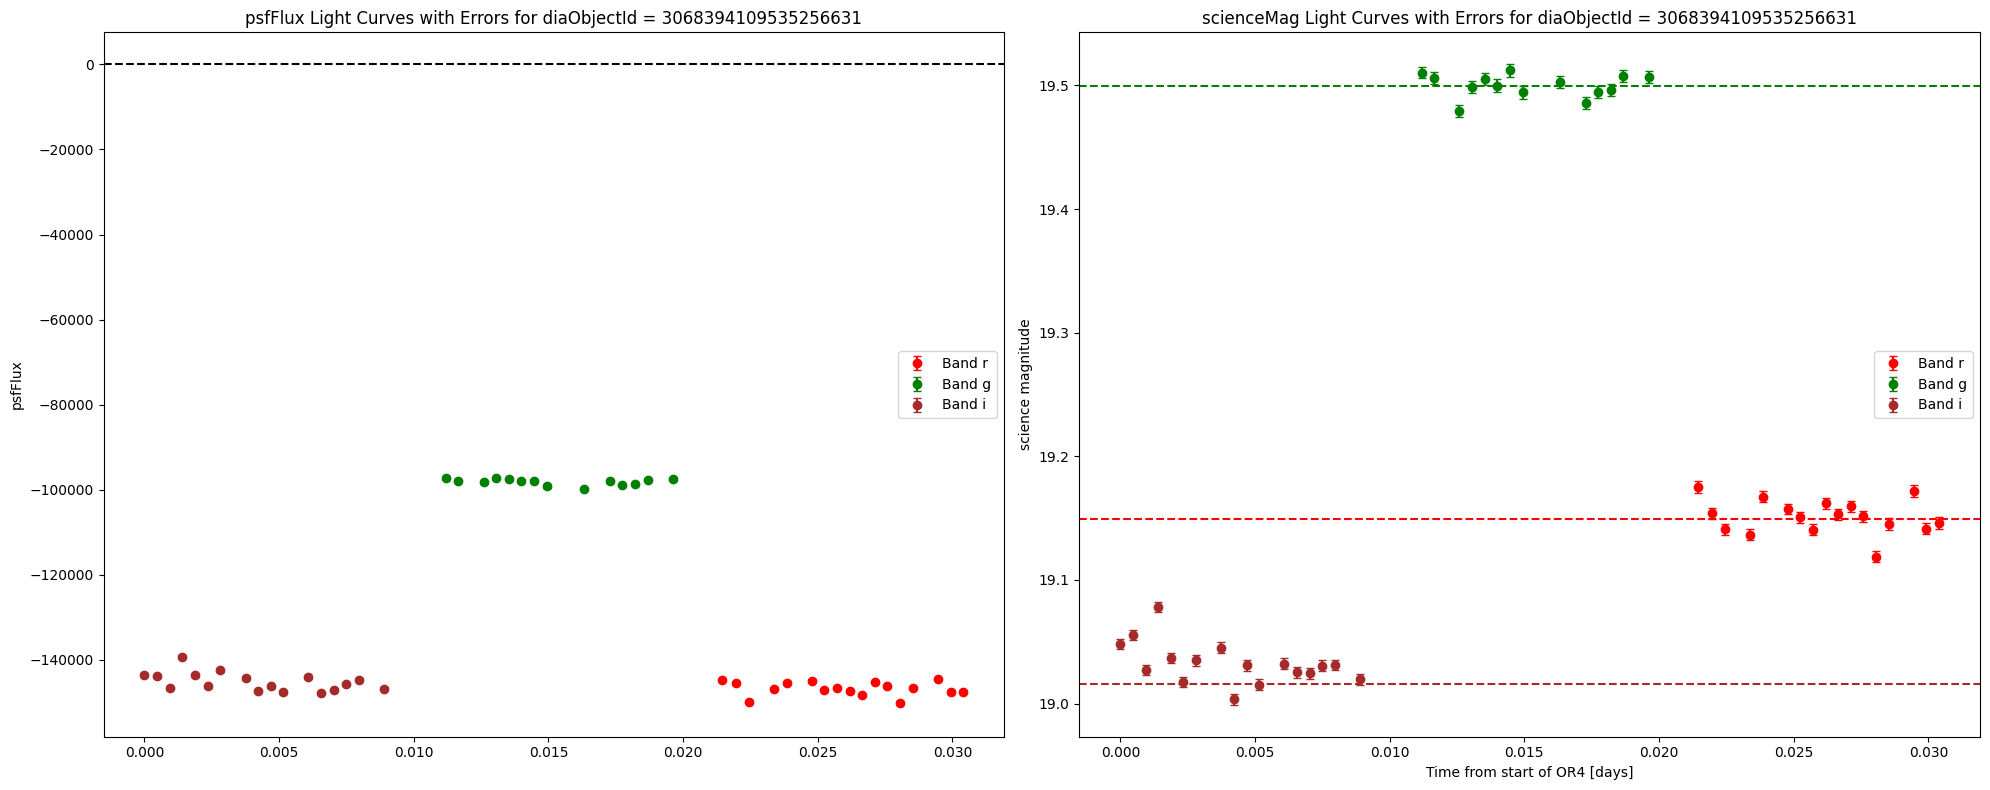

In [87]:
# Create a figure with two subplots (panels)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
band_colors = {'g': 'green', 'r': 'red', 'i': 'brown'}

for b in single_src["band"].unique():
    # Filter to get data for specific band
    band_mask = single_src["band"] == b
    single_src_band = single_src[band_mask]
    color = band_colors.get(b,"blue")

    # Plot psfFlux for band
    axs[0].errorbar(
        single_src_band["midpointMjdTai"] - min_mjd, 
        single_src_band["psfFlux"], 
        yerr=single_src_band["psfFluxErr"],
        label=f'Band {b}', 
        fmt='o', 
        capsize=3,
        color=color)
    
    science_mag, science_mag_err = create_mag_errors(
        single_src_band["scienceFlux"], 
        single_src_band["scienceFluxErr"])
    
    # Plot scienceMag for band
    axs[1].errorbar(
        single_src_band["midpointMjdTai"] - min_mjd, 
        science_mag,
        yerr=science_mag_err,
        label=f'Band {b}', 
        fmt='o',
        capsize=3,
        color=color)
    
    # Plot horizontal lines for reference magnitudes (use 0.75 offset for variability)
    axs[1].axhline(single_obj_mags[f"mag_{b}"].values[0]+0.75, color=color, linestyle='--')

# Add labels and title for psfFlux panel
axs[0].set_ylabel('psfFlux')
axs[0].set_title(f'psfFlux Light Curves with Errors for diaObjectId = {diaObjectId}')
axs[0].legend()
axs[0].axhline(0, color='black', linestyle='--')

# Add labels and title for scienceFlux panel
axs[1].set_xlabel('Time from start of OR4 [days]')
axs[1].set_ylabel('science magnitude')
axs[1].set_title(f'scienceMag Light Curves with Errors for diaObjectId = {diaObjectId}')
axs[1].legend()

plt.tight_layout()
plt.show()

We cannot identify periodicity for the object in these plots. It can be due to the fact that the period of this object is 3 days and the OR4 data was captured for only 3 days as well. We would need a longer exposure for a sinusoidal curve to be seen.

In [83]:
singleObj_x_truth["period"]

_healpix_29
3151747708490382655    3.016539
Name: period, dtype: double[pyarrow]